In [3]:
import numpy as np
import pandas as pd
## for Deep-learing:
import keras
import tensorflow
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
import tensorflow
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D,Dense
from keras.layers import Dropout,concatenate,Input,Flatten
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
#graphic
import matplotlib.pyplot as plt
#istatiski fonk
import neurokit as nk
import scipy
import warnings
warnings.filterwarnings('ignore')
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint 

In [4]:
import pandas as pd
df = pd.read_csv("data.csv")

In [5]:
df.head()
len(df)

11500

In [6]:
df["OUTPUT_LABEL"] = df.y == 1
df["OUTPUT_LABEL"] = df["OUTPUT_LABEL"].astype(int)
df.pop('y')
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,OUTPUT_LABEL
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [7]:
def calc_prevalence(y_actual):
    # this function calculates the prevalence of the positive class (label = 1)
    return sum(y_actual) / len(y_actual)


print("prevalence of the positive class: %.3f"
    % calc_prevalence(df["OUTPUT_LABEL"].values))

print("# of Columns:", len(df.columns))

prevalence of the positive class: 0.200
# of Columns: 179


In [8]:
collist = df.columns.tolist()
cols_input = collist[0:178]
df_data = df[cols_input + ["OUTPUT_LABEL"]]

# check for duplicated columns in cols_input
dup_cols = set([x for x in cols_input if cols_input.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0, "you have duplicated columns in cols_input"

# check for duplicated columns in df_data
cols_df_data = list(df_data.columns)
dup_cols = set([x for x in cols_df_data if cols_df_data.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0,'you have duplicated columns in df_data'

# check the size of df_data makes sense
assert (len(cols_input) + 1) == len(
    df_data.columns
), "issue with dimensions of df_data or cols_input"

set()
set()


In [9]:
df_data = df_data.sample(n=len(df_data))
df_data = df_data.reset_index(drop=True)
df_valid_test = df_data.sample(frac=0.3)
print("Validation/Test Split Size: %.1f" % (len(df_valid_test) / len(df_data)))

df_test = df_valid_test.sample(frac=0.5)
df_valid = df_valid_test.drop(df_test.index)

df_train_all = df_data.drop(df_valid_test.index)

Validation/Test Split Size: 0.3


In [10]:
# check the prevalence of each
print(
    "Test prevalence(n = %d):%.3f"
    % (len(df_test), calc_prevalence(df_test.OUTPUT_LABEL.values))
)
print(
    "Valid prevalence(n = %d):%.3f"
    % (len(df_valid), calc_prevalence(df_valid.OUTPUT_LABEL.values))
)
print(
    "Train all prevalence(n = %d):%.3f"
    % (len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values))
)

Test prevalence(n = 1725):0.192
Valid prevalence(n = 1725):0.197
Train all prevalence(n = 8050):0.202


In [11]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 11500)


In [12]:
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

n = np.min([len(df_train_pos), len(df_train_neg)])

df_train = pd.concat([df_train_pos.sample(n=n, random_state=69), df_train_neg.sample(n=n, random_state=69)], axis=0, ignore_index=True)

df_train = df_train.sample(n=len(df_train), random_state=69).reset_index(drop=True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 3260):0.500


In [13]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

In [14]:
import pickle
pickle.dump(cols_input, open('cols_input.sav', 'wb'))

In [15]:
# a function to fill missing values with mean of the column if needed
def fill_my_missing(df, df_mean, col2use):
    # This function fills the missing values

    # check the columns are present
    for c in col2use:
        assert c in df.columns, c + ' not in df'
        assert c in df_mean.col.values, c+ 'not in df_mean'
    
    # replace the mean 
    for c in col2use:
        mean_value = df_mean.loc[df_mean.col == c,'mean_val'].values[0]
        df[c] = df[c].fillna(mean_value)
    return df

In [16]:
# create the X and y matrices
X_train = df_train[cols_input].values
X_train_all = df_train_all[cols_input].values
X_valid = df_valid[cols_input].values

XTrain = np.concatenate((X_train, X_valid), axis=0)

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values
YTrain = np.concatenate((y_train, y_valid), axis=0)

print('Training All shapes:',X_train_all.shape)
# print('Training shapes:',X_train.shape, y_train.shape)
print('XTrain shapes, YTrain shapes:',XTrain.shape, YTrain.shape)

from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler()
scaler.fit(X_train_all)

scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))
scaler = pickle.load(open(scalerfile, 'rb'))

# transform our data matrices
X_train_tf = scaler.transform(XTrain)

Training All shapes: (8050, 178)
XTrain shapes, YTrain shapes: (4985, 178) (4985,)


In [17]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity[0])
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 
thres=0.5

# İstatistik Fonksiyonları

In [18]:
def hjorth(a):
    first_deriv = np.diff(a)
    second_deriv = np.diff(a,2)

    var_zero = np.mean(a ** 2)
    var_d1 = np.mean(first_deriv ** 2)
    var_d2 = np.mean(second_deriv ** 2)

    activity = var_zero
    morbidity = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / morbidity

    return activity, morbidity, complexity

def medianNorm(a):
    median = np.median(a)
    #print(median)
    xi = np.zeros((len(a)))
    #print(len(a))
    for i in range(len(a)):
        x = a[i]/median
        #print(x)
        xi[i] = x
        
    return xi

def maxminNorm(a):
    maxx = np.amax(a)
    minn = np.amin(a)
    xi = np.zeros((len(a)))
    for i in range(len(a)):
        val = (a[i] - minn ) / (maxx - minn)
        xi[i] = val
    return xi

def stDevNorm(a):
    mean = np.mean(a)
    std = np.std(a)
    xi = np.zeros((len(a)))
    for i in range(len(a)):
        val = ( a[i] - mean) / std
        xi[i] = val
    return xi

def sigmoidNorm(a):
    xi = np.zeros((len(a)))
    for i in range(len(a)):
        up = np.exp(a[i]) - np.exp(-a[i])
        down = np.exp(a[i]) + np.exp(-a[i])
        xi[i] = up / down
    return xi
def DmaxminNorm(a):
    maxx = np.amax(a)
    minn = np.amin(a)
    xi = np.zeros((len(a)))
    for i in range(len(a)):
        val = (0.8*(a[i] - minn ) ) / (maxx - minn)
        xi[i] = val + 0.1
    return xi
def zeroCrossing(a):
    zcr = 0
    sgn = np.zeros((len(a)-1))
    for i in range(len(a)-1):
        sgn[i] = a[i]/a[i+1]
        if(sgn[i] < 0):
            zcr +=1
    return zcr

In [19]:
X_columns = ['Mean_time', 'StandarS_time','Kurt_time',
               'Skewness_time','Activity_time', 'Complexity_time','Morbidity_time','Mad_time']
Y_columns = ['label']

In [20]:
X_train_st = pd.DataFrame(columns = X_columns)
y_train_st = pd.DataFrame(columns = Y_columns)

In [21]:
for i in range(XTrain.shape[0]):
    activity, morbidity, complexity = hjorth(X_train_tf[i])
    mad = nk.mad(X_train_tf[i])
    X_train_st.loc[i] = np.array([np.mean(X_train_tf[i]), np.std(X_train_tf[i]), 
                                         scipy.stats.kurtosis(X_train_tf[i]),
                                         scipy.stats.skew(X_train_tf[i]),
                                         activity, morbidity, complexity, mad])
    y_train_st.loc[i] = YTrain[i]
X_train_st.head(2)

,Mean_time,StandarS_time,Kurt_time,Skewness_time,Activity_time,Complexity_time,Morbidity_time,Mad_time
0,-0.019894,0.680175,0.989738,1.315704,0.463034,0.362118,2.058017,0.289498
1,-0.241755,0.567382,-0.127283,-0.431650,0.380368,0.428916,1.433007,0.318595


In [22]:
X_train_st.to_csv('X_train_st.csv',index=False)

In [23]:
X_train_tf = X_train_tf.reshape((X_train_tf.shape[0], 1,X_train_tf.shape[1]))

print(X_train_tf.shape) 

(4985, 1, 178)


In [24]:
# X_train_zm = np.copy(X_train_tf)
# X_train_zm = X_train_zm.reshape((X_train_zm.shape[0],X_train_zm.shape[2]))
# zmarr = []
# for i in range(X_train_zm.shape[0]):
#     cr_row = X_train_zm[i,:]
#     #print(cr_row.shape)
#     cr_row = cr_row.reshape(178,1)
#     # print(cr_row.shape)      
#     zm = mh.features.zernike_moments(cr_row,1,19)
#     zmarr.append(zm)
    
# print(np.asarray(zmarr).shape)
# X_train_zmoment = np.asarray(zmarr)

In [25]:
def build_model(output=1):
    inputA = Input(shape=(1,178),name="LSTM_input")
    inputB = Input(shape=(8,),name="STATS_input")
    
    x = LSTM(120,return_sequences=True)(inputA)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', name='layer1')(x)
    x = Dense(64, activation='relu', name='layer2')(x)
    x = Model(inputs=inputA, outputs=x)
      
    y = Dense(128, activation='relu', name='layer_1')(inputB)
    y = Dense(64, activation='relu', name='layer_2')(y)
    y = Model(inputs=inputB, outputs=y)
    
    combined = concatenate([x.output,y.output])
    
    z = Dense(32, activation="relu")(combined)
    # z = Dense(8, activation="relu")(z)
    z = Dense(output, activation="sigmoid")(z)


    model = Model(inputs = [x.input,y.input], outputs=z)
    adam = Adam(1e-3)
    rmsprop = RMSprop(1e-3)

    model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
    # model.summary()
    
    return model

model = build_model()

In [26]:
callbacks = [EarlyStopping(monitor='loss', patience=15,mode='min')]

history = model.fit([X_train_tf,X_train_st], YTrain, epochs=100, batch_size=32, 
                     verbose=1, shuffle=False)


Epoch 1/100
4985/4985 [==============================] - 2s 373us/step - loss: 0.0476 - accuracy: 0.9452
Epoch 2/100
4985/4985 [==============================] - 1s 236us/step - loss: 0.0207 - accuracy: 0.9761
Epoch 3/100
4985/4985 [==============================] - 1s 247us/step - loss: 0.0160 - accuracy: 0.9809
Epoch 4/100
4985/4985 [==============================] - 1s 243us/step - loss: 0.0147 - accuracy: 0.9831
Epoch 5/100
4985/4985 [==============================] - 1s 235us/step - loss: 0.0134 - accuracy: 0.9844
Epoch 6/100
4985/4985 [==============================] - 1s 232us/step - loss: 0.0113 - accuracy: 0.9878
Epoch 7/100
4985/4985 [==============================] - 1s 239us/step - loss: 0.0087 - accuracy: 0.9910
Epoch 8/100
4985/4985 [==============================] - 1s 239us/step - loss: 0.0099 - accuracy: 0.9876
Epoch 9/100
4985/4985 [==============================] - 1s 229us/step - loss: 0.0091 - accuracy: 0.9902
Epoch 10/100
4985/4985 [==============================

In [27]:
model.save_weights("model.h5")

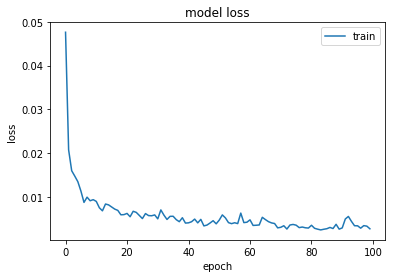

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [29]:
X_test = df_test[cols_input].values

y_test = df_test['OUTPUT_LABEL'].values

In [30]:
print(X_test.shape)

(1725, 178)


In [31]:
scaler  = StandardScaler()
scaler.fit(X_test)
X_test_tf = scaler.transform(X_test)

In [32]:
X_columns_t = ['Mean_time', 'StandarS_time','Kurt_time',
               'Skewness_time','Activity_time', 'Complexity_time','Morbidity_time','Mad_time']
Y_columns_t = ['label']

In [33]:
X_test_st = pd.DataFrame(columns = X_columns_t)
y_test_st = pd.DataFrame(columns = Y_columns_t)

In [34]:
for i in range(X_test.shape[0]):
    activity, morbidity, complexity = hjorth(X_test_tf[i])
    mad = nk.mad(X_test_tf[i])
    X_test_st.loc[i] = np.array([np.mean(X_test_tf[i]), np.std(X_test_tf[i]), 
                                         scipy.stats.kurtosis(X_test_tf[i]),
                                         scipy.stats.skew(X_test_tf[i]),
                                         activity, morbidity, complexity, mad])
    y_test_st.loc[i] = y_test[i]
X_test_st.head(2)

,Mean_time,StandarS_time,Kurt_time,Skewness_time,Activity_time,Complexity_time,Morbidity_time,Mad_time
0,0.310854,0.330537,-0.329556,0.193588,0.205885,0.490538,2.613884,0.231769
1,-0.660874,1.162641,1.684505,0.991490,1.788489,0.266811,1.977902,0.340305


In [35]:
X_test_st.to_csv('X_test_st.csv',index=False)

In [36]:
X_test_tf = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_test_tf.shape, X_test_st.shape)

(1725, 1, 178) (1725, 8)


In [37]:
y_test_preds = model.predict([X_test_tf,X_test_st])

In [38]:
thresh = 0.5
print('Test:')
mode_auc, knn_accuracy, model_recall, \
     model_precision, model_specificity = print_report(y_test,y_test_preds, thresh)

Test:
AUC:0.984
accuracy:0.919
recall:0.970
precision:0.713
specificity:0.915
prevalence:0.192
 


In [39]:
score = model.evaluate([X_test_tf,X_test_st ], y_test,verbose=1)

print(score)

1725/1725 [==============================] - 0s 148us/step
[0.07199846181039955, 0.9194203019142151]
